<a href="https://colab.research.google.com/github/Anitayea/Linear_and_Nonlinear_Optimization/blob/recitations/recitation_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recitation 6



*   Quiz
*   questions
*   More Gurobi



1) [T/F] In a sequential zero-sum game, it is always weakly preferrable to
play first.

ANSWER: False - see example in class of soccer players: if goalie goes second they are better off. This is equivalent to comparing min max vs max min 

---

2) [T/F] A zero-sum game has always an equilibrium in pure strategy.

ANSWER: False - in zero-sum pure strategy there is not allways an equilibrium - see example in class. 
example: rock paper sissors

---

3) [T/F] A zero-sum game has always an equilibrium in mixed strategy.

ANSWER: True - theorem in class. in notes on page claim made on page 88 with proof following and statement of theorem on page 97.

---


4) [T/F] An equilibrium in mixed strategy has always a unique equilibrium in
mixed strategy.

ANSWER: False - can we find a counter example? 
example: player A and player B each have options a1, a2 and b1, b2. The payoff is 1 for player A no matter what each player chooses. So any strategy is optimal. 

---


5) [T/F] There is always a best response in pure strategy.

ANSWER: True - you always have the opprotunity to make the best possible response. This was also a proposition in class though I am not sure where it is explicitly stated in the notes. One clear way to see this is that once the first player makes a choice the second player then chooses their payout and either one choice is optimal, or if more than one is any of them are rather than needing to randomly select.

---


6) Consider the zero-sum game where player 1 plays $i\in \left\{
1,...,5\right\} $ and player 2 plays $j\in \left\{ 1,...,5\right\} $. The
payoff to player 1 is $\ 1$ if $i>j$, $0$ if $i=j$, and $-2$ if $i<j$. What
is the expected payoff of player 1 in a mixed strategy equilibrium?


ANSWER: 0 - player 1's best bet will always be to select the largest number. The same applies for player 2. Thus both will always choose 5 and the payoff will be 0.

## Gurobi examples

In [ ]:
import os
import pandas as pd
import numpy as np
import scipy.sparse as sp
!pip install osmnx
#import osmnx as ox
import networkx as nx
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] #resize plots
from matplotlib.animation import FuncAnimation
!pip install gurobipy
import gurobipy as grb

#thepath = os.path.join(os.getcwd(),'data_mec_optim/')
thepath = 'https://raw.githubusercontent.com/math-econ-code/mec_optim_2021-01/master/data_mec_optim/'

In [ ]:
class network_problem:
    def __init__(self,nodesList,arcsList,costsList):
        self.nbNodes = len(nodesList)
        self.nbArcs = len(arcsList)
        self.nodesList = nodesList
        self.arcsList = arcsList
        self.costsList = costsList
        self.nodesDict = {node:node_ind for (node,node_ind) in zip(self.nodesList,range(self.nbNodes))}
        self.arcsDict = {arc:arc_ind for (arc,arc_ind) in zip(self.arcsList,range(self.nbArcs))}
        print('Number of nodes='+str(self.nbNodes)+'; number of arcs='+str(self.nbArcs)+'.')

Example: directed graph

Number of nodes=4; number of arcs=5.


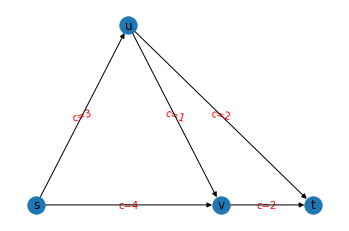

In [ ]:
example_graph = nx.DiGraph() #create empty directed graph
arcslist = [('s','u'),('u','v'),('s','v'),('u','t'),('v','t')] #directed edges
costslist = [3,1,4,2,2]
example_graph.add_edges_from(arcslist)

example_pb = network_problem(list(example_graph.nodes),arcslist,costslist) 

pos = {'s':np.array([0,0]),'u':np.array([1,0.5]),'v':np.array([2,0]),'t':np.array([3,0])} 
nx.draw_networkx_edge_labels(example_graph,pos,edge_labels={e:('c='+str(l)) for (e,l) in zip(arcslist,costslist)},font_color='red')
nx.draw(example_graph,pos,with_labels=True)
plt.show()

In [ ]:
example_pb.nodesDict

{'s': 0, 't': 3, 'u': 1, 'v': 2}

In [ ]:
def Nabla(self):
    data = np.concatenate([-np.ones(self.nbArcs),np.ones(self.nbArcs)])
    arcsIndices = list(range(self.nbArcs))
    arcsOrigins = [self.nodesDict[o] for o,d in self.arcsList]
    arcsDestinations = [self.nodesDict[d] for o,d in self.arcsList]
    theNabla = sp.csr_matrix((data, (arcsIndices+arcsIndices, arcsOrigins+arcsDestinations)), shape = (self.nbArcs,self.nbNodes))
    return(theNabla)

network_problem.Nabla = Nabla

this is a matrix of the arcs, the first row represents the arrow from s to u for example

In [ ]:
example_pb.Nabla().toarray()

array([[-1.,  1.,  0.,  0.],
       [ 0., -1.,  1.,  0.],
       [-1.,  0.,  1.,  0.],
       [ 0., -1.,  0.,  1.],
       [ 0.,  0., -1.,  1.]])

*mu* is 1 on arcs the path uses and 0 for arcs not used. This represents (s,u,v,t)

In [ ]:
# example_pb.arcsList
# example_pb.nodesList
mu = np.array([1,1,0,0,1])
(example_pb.Nabla().transpose() * mu.reshape(-1,1)).reshape(1,-1)

array([[-1.,  0.,  0.,  1.]])

In [ ]:
def pathfinder(self,mu,sind,tind):
    # assume mu is such that $\Nabla^\top \mu =1 on t, =-1 on s, and =0 elsewhere
    t = self.nodesList[tind]
    arcs_active = [(x,y) for (x,y) in self.arcsList if (mu[self.arcsDict[(x,y)]] > 0) ]
    current = self.nodesList[sind]
    path = [current]
    while current != t:
        (x,y) = next((x,y) for (x,y) in arcs_active if x==current)
        path.append(y)
        current = y
        arcs_active.remove((x,y))
    return(path)
    

network_problem.pathfinder = pathfinder

In [ ]:
example_pb.pathfinder(mu,0,3)

['s', 'u', 'v', 't']

In [ ]:
def mincostflow(self,q):
    Nabla = self.Nabla()
    m=grb.Model()
    p = m.addMVar(shape=self.nbNodes, name="p", lb = float('-inf'))
    m.setObjective(q @ p, grb.GRB.MAXIMIZE)
    m.addConstr( Nabla @ p <= np.array(self.costsList), name="Constr")
    m.optimize()
    if m.status == grb.GRB.Status.OPTIMAL:
        p_z = m.getAttr('x')
        mu_a = m.getAttr('pi')
    return np.array((p_z,mu_a),dtype=object)

network_problem.mincostflow = mincostflow

In [ ]:
p_z,mu_a = example_pb.mincostflow(np.array([[-1.,  0.,  0.,  1.]]))


Restricted license - for non-production use only - expires 2023-10-25
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 5 rows, 4 columns and 10 nonzeros
Model fingerprint: 0xd068e937
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 5 rows and 4 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0000000e+00   0.000000e+00   2.000000e-06      0s

Solved in 0 iterations and 0.03 seconds (0.00 work units)
Optimal objective  5.000000000e+00


In [ ]:
print(f'\np_z={p_z}, and \nμ_a = {mu_a}' )


p_z=[-3.0, 0.0, 0.0, 2.0], and 
μ_a = [1.0, 0.0, 0.0, 1.0, -0.0]


In [ ]:
example_pb.arcsList

[('s', 'u'), ('u', 'v'), ('s', 'v'), ('u', 't'), ('v', 't')]

In [ ]:
example_pb.pathfinder(mu_a,0,3)

['s', 'u', 't']

In [ ]:
example_pb.nodesList

['s', 'u', 'v', 't']

In [ ]:
thepath = 'https://raw.githubusercontent.com/math-econ-code/mec_optim_2021-01/master/data_mec_optim/'

soviet mathematician minimizing cost of transporting concrete from factories to cities

In [ ]:
soviet_df = pd.read_csv(thepath+'networks_sovietplanning/distances.csv', sep=',',encoding = "ISO-8859-1")

soviet_df

,X,Arkhangelsk,Yaroslavl,Murom,Balakhonikha,Dzerzhinsk,Kishert,Sverdlovsk,Artemovsk,Iledzhk,Dekonskaya,demand:
0,Agryz,NaN,NaN,NaN,709.0,1064.0,693.0,NaN,NaN,NaN,NaN,2.0
1,Aleksandrov,NaN,NaN,NaN,NaN,397.0,NaN,NaN,1180.0,NaN,NaN,4.0
2,Almaznaya,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,NaN,65.0,1.5
3,Alchevskaya,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.0,NaN,114.0,4.0
4,Baku,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1554.0,NaN,1563.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
64,Shchigry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,566.0,NaN,549.0,4.0
65,Yudino,NaN,NaN,NaN,403.0,757.0,999.0,NaN,NaN,NaN,NaN,0.5
66,Yama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,NaN,52.0,5.0
67,Yasinovataya,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,NaN,93.0,6.0


In [ ]:
nbPlants = soviet_df.shape[1]-2
nbCities = soviet_df.shape[0]-1
arcsList = []
costslist = []
nodesList = [soviet_df.columns.values[plant+1]+ ' plant' for plant in range(nbPlants)] + [soviet_df.iloc[city,0]+ " city" for city in range(nbCities)]
for plant in range(nbPlants):
  for city in range(nbCities):
    if not pd.isna(soviet_df.iloc[city,plant+1]):
      arcsList.append((nodesList[plant],nodesList[nbPlants+city]))
      costslist.append(soviet_df.iloc[city,plant+1])


In [ ]:
q = np.concatenate((-soviet_df.iloc[68,1:-1], soviet_df.iloc[0:-1,11]))
soviet_pb = network_problem(nodesList, arcsList, costslist)

Number of nodes=78; number of arcs=155.


In [ ]:
p_z, mu_a = soviet_pb.mincostflow(q)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 155 rows, 78 columns and 310 nonzeros
Model fingerprint: 0xa2640c49
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+03]
Presolve removed 78 rows and 13 columns
Presolve time: 0.01s
Presolved: 77 rows, 65 columns, 259 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      52    3.9505200e+05   0.000000e+00   0.000000e+00      0s

Solved in 52 iterations and 0.02 seconds (0.00 work units)
Optimal objective  3.950520000e+05


In [ ]:
arcsList[0:5]

[('Arkhangelsk plant', 'Vologda city'),
 ('Arkhangelsk plant', 'Galich city'),
 ('Arkhangelsk plant', 'Leningrad city'),
 ('Arkhangelsk plant', 'Perm\x92 city'),
 ('Arkhangelsk plant', 'Petrozavodsk city')]

In [ ]:
mu_a[0:5]

[2.0, 0.0, 2.0, 0.0, 1.0]